In [38]:
import os
import jieba
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


In [20]:
# 1. 读取数据

file_path = "filtered_cnews.train.txt"
texts = []
labels = [] # 初始化，准备读取数据

with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split('\t') # 将每行分割
        if len(parts) == 2: # 判断分割后的parts长度是否为2(标签和内容)
            label, content = parts
            texts.append(content)
            labels.append(label)


In [21]:
# 2. 去除停用词及分词

def load_stopwords(path='stopwords.txt'):
    with open(path, 'r', encoding='utf-8') as f:
        return set(line.strip() for line in f if line.strip())
stopwords = load_stopwords()

texts_cut = []
for text in texts:
    words = jieba.lcut(text)
    filtered = [w for w in words if w not in stopwords]
    texts_cut.append(" ".join(filtered))

# 3. 划分训练集,验证集和测试集(8:1:1)

X_train, X_temp, y_train, y_temp = train_test_split(texts_cut, labels, test_size=0.2, random_state=42, stratify=labels)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# 4. 文本向量化

vectorizer = TfidfVectorizer(max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
X_valid_vec = vectorizer.transform(X_valid)
X_test_vec = vectorizer.transform(X_test)


In [39]:
# 混淆矩阵的绘制工具

matplotlib.rcParams['font.family'] = 'SimHei'
matplotlib.rcParams['axes.unicode_minus'] = False

def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


朴素贝叶斯分类报告:
              precision    recall  f1-score   support

          体育     0.9980    0.9960    0.9970       500
          家居     0.9475    0.9380    0.9427       500
          房产     0.9205    0.9260    0.9232       500
          教育     0.9413    0.9300    0.9356       500
          科技     0.9396    0.9640    0.9516       500
          财经     0.9456    0.9380    0.9418       500

    accuracy                         0.9487      3000
   macro avg     0.9487    0.9487    0.9487      3000
weighted avg     0.9487    0.9487    0.9487      3000



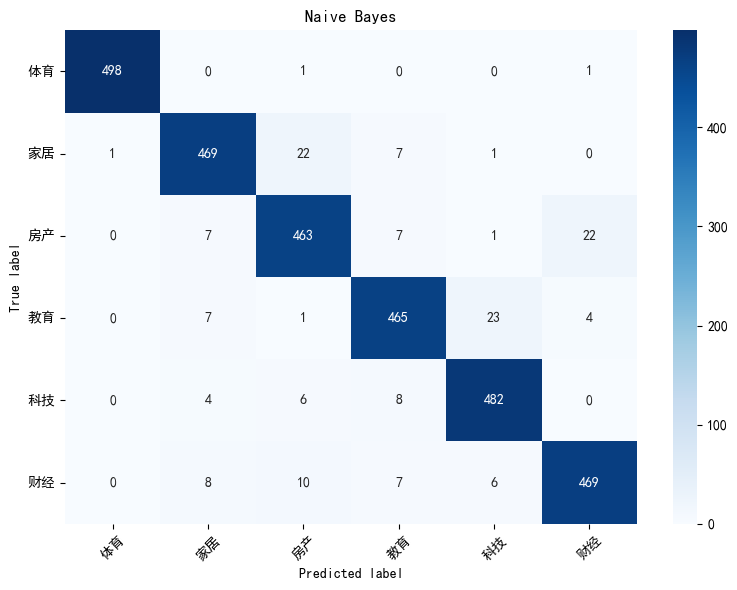

In [40]:
# 5. 方法一:朴素贝叶斯

nb = MultinomialNB()
nb.fit(X_train_vec, y_train)
y_pred_nb = nb.predict(X_test_vec)

print("朴素贝叶斯分类报告:")
print(classification_report(y_test, y_pred_nb, digits=4))

cm_nb = confusion_matrix(y_test, y_pred_nb)
plot_confusion_matrix(cm_nb, sorted(set(labels)), "Naive Bayes")


KNN分类报告:
              precision    recall  f1-score   support

          体育     1.0000    0.5260    0.6894       500
          家居     0.2681    0.9980    0.4227       500
          房产     0.9689    0.3120    0.4720       500
          教育     0.9953    0.4280    0.5986       500
          科技     0.9945    0.3600    0.5286       500
          财经     0.9875    0.6300    0.7692       500

    accuracy                         0.5423      3000
   macro avg     0.8691    0.5423    0.5801      3000
weighted avg     0.8691    0.5423    0.5801      3000



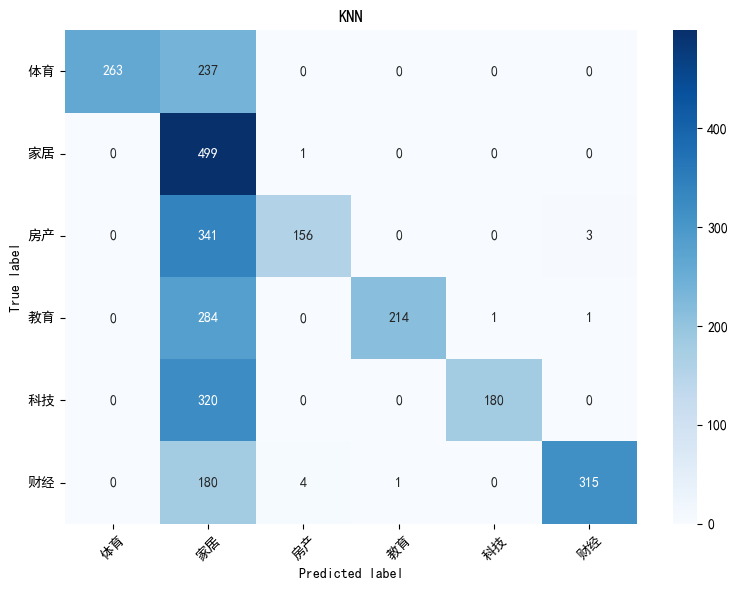

In [41]:
# 6. 方法二:KNN（k=5）

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_vec, y_train)
y_pred_knn = knn.predict(X_test_vec)

print("KNN分类报告:")
print(classification_report(y_test, y_pred_knn, digits=4))

cm_knn = confusion_matrix(y_test, y_pred_knn)
plot_confusion_matrix(cm_knn, sorted(set(labels)), "KNN")


SVD降维
GBDT训练开始
GBDT训练完成
GBDT分类报告:
              precision    recall  f1-score   support

          体育     0.9960    0.9940    0.9950       500
          家居     0.9580    0.9580    0.9580       500
          房产     0.9511    0.9340    0.9425       500
          教育     0.9306    0.9380    0.9343       500
          科技     0.9518    0.9480    0.9499       500
          财经     0.9488    0.9640    0.9563       500

    accuracy                         0.9560      3000
   macro avg     0.9560    0.9560    0.9560      3000
weighted avg     0.9560    0.9560    0.9560      3000



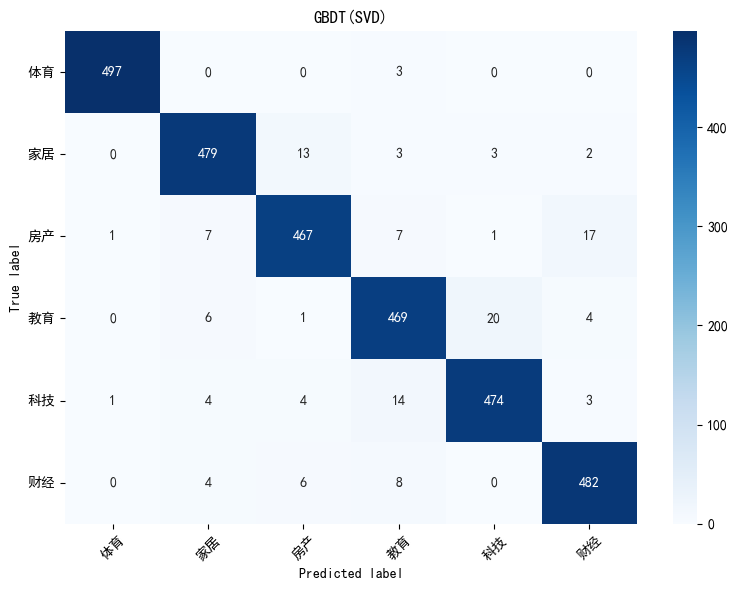

In [42]:
# 7. 方法三:GBDT
# GBDT不太适合直接处理稀疏的TF-IDF向量，因此使用SVD降维。

print("SVD降维")
svd = TruncatedSVD(n_components=300, random_state=42)
X_train_svd = svd.fit_transform(X_train_vec)
X_test_svd = svd.transform(X_test_vec)
print("GBDT训练开始")
gbdt = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbdt.fit(X_train_svd, y_train)
print("GBDT训练完成")
y_pred_gbdt = gbdt.predict(X_test_svd)

print("GBDT分类报告:")
print(classification_report(y_test, y_pred_gbdt, digits=4))

cm_gbdt = confusion_matrix(y_test, y_pred_gbdt)
plot_confusion_matrix(cm_gbdt, sorted(set(labels)), "GBDT(SVD)")
